In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [77]:
df=pd.read_csv('Admission_Predict_Ver1.1.csv')

In [78]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [79]:
print("the total number of null values in dataset: ",df.isnull().sum().sum())

the total number of null values in dataset:  0


In [80]:
print("the total number of samples: ", df.shape[0])
print("the total number of features is :",df.shape[1])

the total number of samples:  500
the total number of features is : 9


In [81]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [82]:
#finding the threshold
threshold = df['Chance of Admit '].describe()['75%']
df['admitted']= (df['Chance of Admit ']>=threshold).astype(int)
df.drop(columns=['Serial No.', 'Chance of Admit '])
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,admitted
0,1,337,118,4,4.5,4.5,9.65,1,0.92,1
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0


In [83]:
#balancing the dataset
ad_cnt= df['admitted'].value_counts()
print("0:not admitted , 1: admitted \n")
print("Before balancing the dataset ")
print(ad_cnt)

df_minority =df[df['admitted']==1]
df_majority=df[df['admitted']==0]

df_minority_upsampled= resample(df_minority, replace=True, n_samples=len(df_majority),random_state=42)
balanced = pd.concat([df_majority, df_minority_upsampled])
bal_cnt= balanced['admitted'].value_counts()
print("\nafter balancing the dataset")
print(bal_cnt)

0:not admitted , 1: admitted 

Before balancing the dataset 
admitted
0    367
1    133
Name: count, dtype: int64

after balancing the dataset
admitted
0    367
1    367
Name: count, dtype: int64


In [84]:
#selecting features
x= balanced[['GRE Score','University Rating','CGPA']]
y= balanced['admitted']


In [85]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)
def train_and_evaluate_pruned(criterion, x_train,x_test,y_train,y_test):
    model=DecisionTreeClassifier(
        criterion=criterion,
        random_state=42,
        min_samples_split=15,
        min_samples_leaf=5,
        max_depth=4
    )
    model.fit(x_train,y_train)
    tr_pred =model.predict(x_train)
    te_pred=model.predict(x_test)

    tr_accuracy= accuracy_score(y_train,tr_pred)
    te_accuracy=accuracy_score(y_test,te_pred)
    tr_conf =confusion_matrix(y_train,tr_pred)
    te_conf =confusion_matrix(y_test,te_pred)
    tr_cr= classification_report(y_train,tr_pred)
    te_cr=classification_report(y_test,te_pred)

    return{
        "criterion": criterion,
        "model":model,
        "test_accuracy":te_accuracy,
        "train_accuracy":tr_accuracy,
        "train_confusion_matrix": tr_conf,
        "test_confusion_matrix":te_conf,
        "train_classification_report":tr_cr,
        "test_classification_report":te_cr
    }

def display_results(results, feature_names):
    print(f"criterion is : {results['criterion']}")
    print(f"training accuracy score is : {results['train_accuracy']:.3f}")
    print(f"testing accuracy score is : {results['test_accuracy']:.3f}")
    print(f"training classifcation report : {results['train_classification_report']}")
    print(f"testing classifcation report : {results['test_classification_report']}")
    #printing confusion matrix
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    sns.heatmap(results['train_confusion_matrix'],annot=True,fmt='d',cbar=False, cmap='Blues')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title(f" training confusion matrix for {results['criterion'].capitalize()}")

    plt.subplot(1,2,2)
    sns.heatmap(results['test_confusion_matrix'],annot=True,fmt='d',cbar=False, cmap='Oranges')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title(f" testing confusion matrix for {results['criterion'].capitalize()}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,6))
    plot_tree(results['model'],filled=True, feature_names=feature_names, class_names=['admitted','not admitted'])
    plt.title(f"classification tree using {results['criterion']} ")
    plt.show()

criterion is : gini
training accuracy score is : 0.955
testing accuracy score is : 0.935
training classifcation report :               precision    recall  f1-score   support

           0       0.96      0.94      0.95       263
           1       0.95      0.97      0.96       287

    accuracy                           0.95       550
   macro avg       0.96      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550

testing classifcation report :               precision    recall  f1-score   support

           0       0.99      0.89      0.94       104
           1       0.88      0.99      0.93        80

    accuracy                           0.93       184
   macro avg       0.93      0.94      0.93       184
weighted avg       0.94      0.93      0.94       184



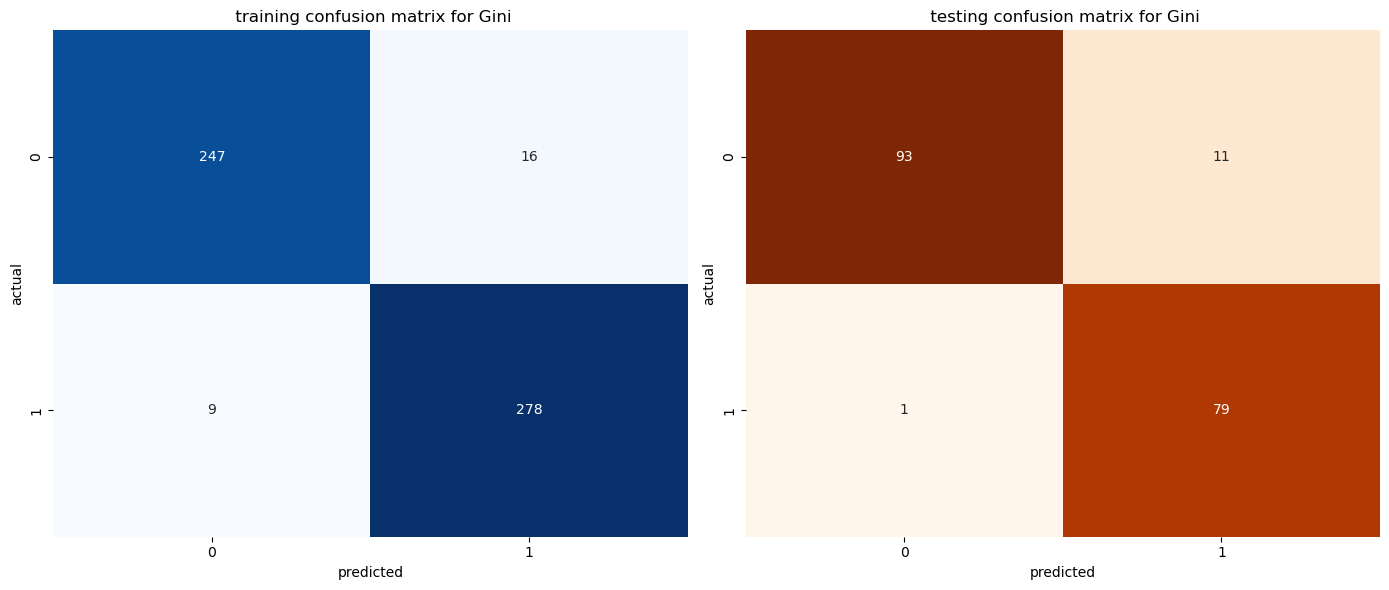

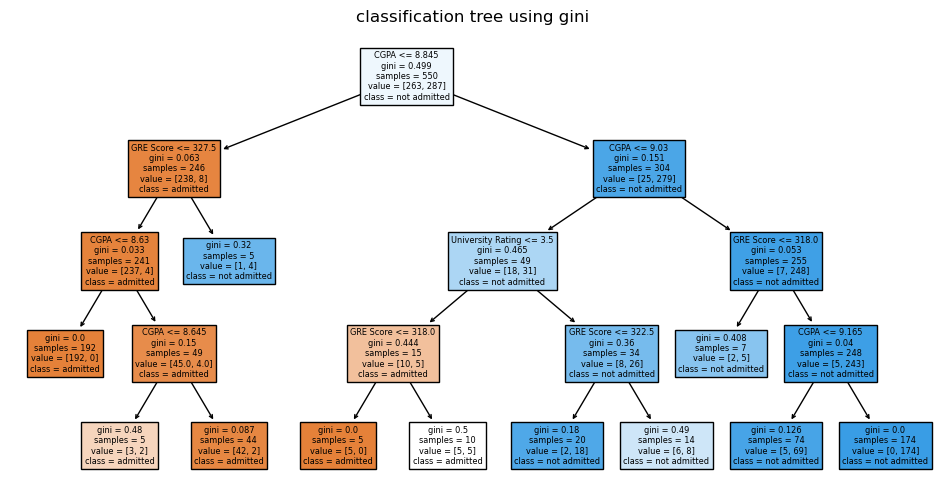

In [86]:
gini_results = train_and_evaluate_pruned('gini',x_train,x_test,y_train,y_test)
display_results(gini_results, x_train.columns)

criterion is : entropy
training accuracy score is : 0.956
testing accuracy score is : 0.924
training classifcation report :               precision    recall  f1-score   support

           0       0.99      0.92      0.95       263
           1       0.93      0.99      0.96       287

    accuracy                           0.96       550
   macro avg       0.96      0.95      0.96       550
weighted avg       0.96      0.96      0.96       550

testing classifcation report :               precision    recall  f1-score   support

           0       1.00      0.87      0.93       104
           1       0.85      1.00      0.92        80

    accuracy                           0.92       184
   macro avg       0.93      0.93      0.92       184
weighted avg       0.94      0.92      0.92       184



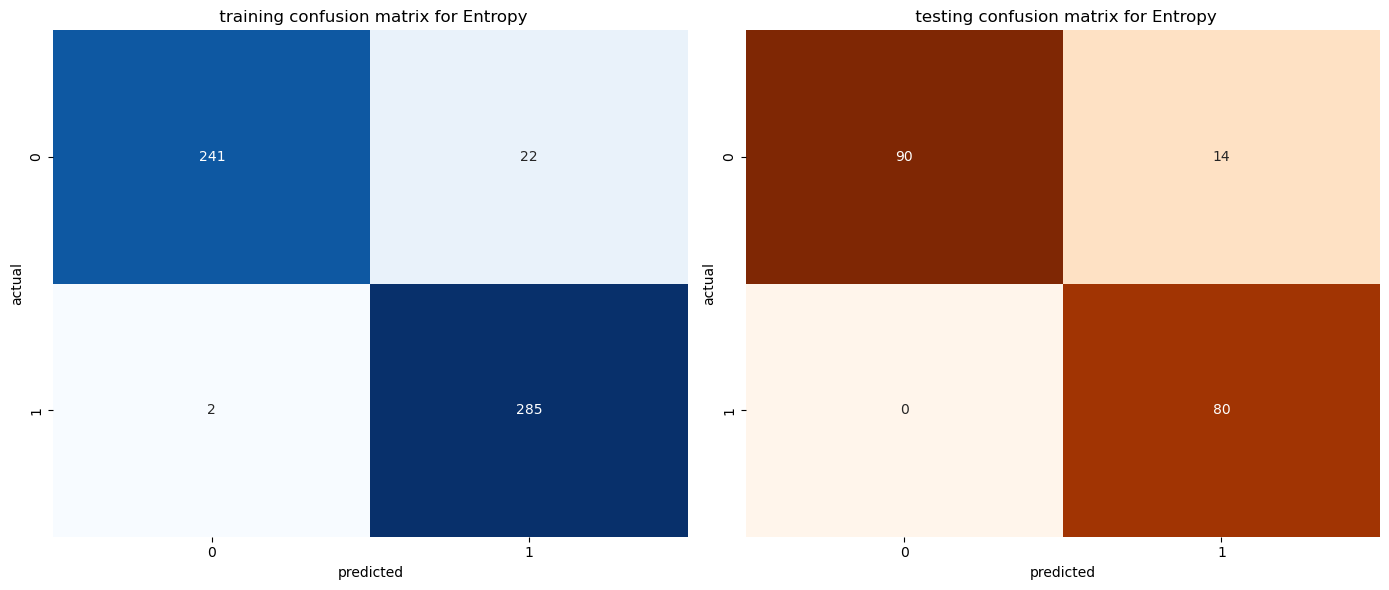

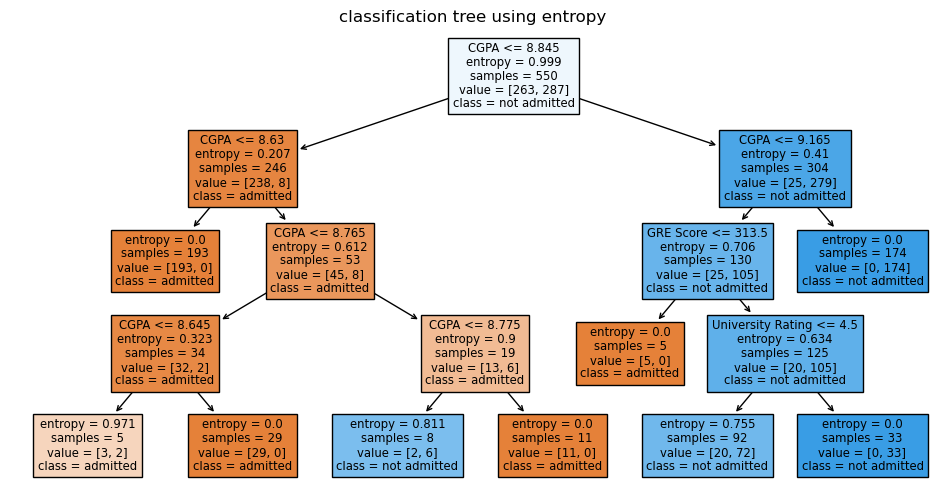

In [87]:
entropy_results = train_and_evaluate_pruned('entropy',x_train,x_test,y_train,y_test)
display_results(entropy_results, x_train.columns)